In [1]:
import numpy as np
from graphviz import Digraph

In [2]:
class Variable:
    count = 0
    def __init__(self, value, parents=(), op=''):
        self.value = value # keeps track of the function value f(x)
        self.grad = 0      # keeps track of the derivative f'(x)
        self.parents = set(parents)
        self.op = op       # parent operation
        self.backward_step = lambda: None
        self.name = 'x_' + str(Variable.count)
        Variable.count += 1
    
    def __repr__(self):
        return f"Variable(value={self.value}, grad={self.grad}, name=\"{self.name}\", op=\"{self.op}\", n_parents={len(self.parents)})"

    def __add__(self, other):
        other = other if isinstance(other, Variable) else Variable(other)
        out = Variable(self.value + other.value, (self, other), op='+')
        
        def _backward():
            self.grad += out.grad
            other.grad += out.grad
            
        out.backward_step = _backward
        return out

    def __radd__(self, other):
        other = other if isinstance(other, Variable) else Variable(other)
        out = Variable(self.value + other.value, (self, other), op='+')
        
        def _backward():
            self.grad += out.grad
            other.grad += out.grad
            
        out.backward_step = _backward
        return out

    def __mul__(self, other):
        other = other if isinstance(other, Variable) else Variable(other)
        out = Variable(self.value * other.value, (self, other), op='*')
        
        def _backward():
            self.grad += other.value * out.grad
            other.grad += self.value * out.grad

        out.backward_step = _backward
        return out

    def _rmul__(self, other):
        return self * other

    def __pow__(self, number):
        assert isinstance(number, (int, float)), "only supporting int/float powers"
        out = Variable(np.power(self.value, number), (self,), op=f'^{number}')

        def _backward():
            self.grad += out.grad * (number * self.value ** (number - 1))

        out.backward_step = _backward
        return out

    def __neg__(self):
        return self * -1

    def __sub__(self, other):
        other = other if isinstance(other, Variable) else Variable(other)
        out = Variable(self.value - other.value, (self, other), op='-')
        
        def _backward():
            self.grad += out.grad
            other.grad -= out.grad

        out.backward_step = _backward
        return out

    def __rsub__(self, other):
        return other - self

    def __truediv__(self, other):
        other = other if isinstance(other, Variable) else Variable(other)
        return self * other ** -1

    def __rtruediv__(self, other):
        other = other if isinstance(other, Variable) else Variable(other)
        return other * self ** -1

    def sin(self):
        out = Variable(np.sin(self.value), (self,), op='sin')

        def _backward():
            self.grad += out.grad * np.cos(self.value)

        out.backward_step = _backward
        return out

    def cos(self):
        out = Variable(np.cos(self.value), (self,), op='cos')

        def _backward():
            self.grad -= np.sin(self.value) * out.grad

        out.backward_step = _backward
        return out

    def tan(self):
        return self.sin() / self.cos()

    def log(self):
        out = Variable(np.log(self.value), (self,), op='log')

        def _backward():
            self.grad += (1 / self.value) * out.grad

        out.backward_step = _backward
        return out
    
    def exp(self):
        out = Variable(np.exp(self.value), (self,), op='exp')

        def _backward():
            self.grad += out.grad * np.exp(self.value)

        out.backward_step = _backward
        return out
        
    def topsort(self):
        sorted_nodes = []
        visited = set()
        
        def dfs(v):
            if v in visited:
                return
            visited.add(v)
            for nei in v.parents:
                dfs(nei)
            sorted_nodes.append(v)
            
        dfs(self)
        return sorted_nodes

    def backward(self):
        topo = self.topsort()
        self.grad = 1

        for node in reversed(topo):
            print(node)
            node.backward_step()

    def build_graph(self):
        edges, nodes = set(), set()

        def dfs(v):
            if v not in nodes:
                nodes.add(v)
                for nei in v.parents:
                    edges.add((nei, v))
                    dfs(nei)
            
        dfs(self)
        return nodes, edges

In [3]:
def draw_dag_forward(root, rankdir='LR'):
    assert rankdir in ['LR', 'TB']
    # Compute the nodes and edges using the `trace` function we just
    # described in the `Variable` class.
    nodes, edges = root.build_graph()

    # A diagraph is the kind of visualization we're after.
    # Format is the output type. You can change this to png, jpeg, etc.
    # Rankdir must be either LR (left-to-right) or TB (top-to-bottom)
    dot = Digraph(format='svg', graph_attr={'rankdir': rankdir})
    
    for n in nodes: # For each node
        # Add a node with the machine name of this object
        # There are many kinds of shapes available; https://graphviz.org/doc/info/shapes.html
        # We will use the 'record' shape containing the primal and tangent value rounded
        # to 3 digits.
        dot.node(name=str(id(n)), label = "{%s = %.3f}" % (n.name, n.value), shape='record')
        if n.op: # If this is an op (as in the name op is not empty)
            # Add a node and name it the machine name + the op
            dot.node(name=str(id(n)) + n.op, label=n.op)
            # Connect an edge between this newly created op and the parent node
            dot.edge(str(id(n)) + n.op, str(id(n)))
    
    for n1, n2 in edges: # For the nodes in each edge
        # Add an edge
        dot.edge(str(id(n1)), str(id(n2)) + n2.op)
    
    # Return the graph
    return dot

def draw_dag_backward(root, rankdir='RL'):
    assert rankdir in ['LR', 'RL', 'TB']
    # Compute the nodes and edges using the `trace` function we just
    # described in the `Variable` class.
    nodes, edges = root.build_graph()

    # A diagraph is the kind of visualization we're after.
    # Format is the output type. You can change this to png, jpeg, etc.
    # Rankdir must be either LR (left-to-right) or TB (top-to-bottom)
    dot = Digraph(format='png', graph_attr={'rankdir': rankdir})
    
    for n in nodes: # For each node
        # Add a node with the machine name of this object
        # There are many kinds of shapes available; https://graphviz.org/doc/info/shapes.html
        # We will use the 'record' shape containing the primal and tangent value rounded
        # to 3 digits.
        dot.node(name=str(id(n)), label = "{dy/d%s = %.3f} | {%s = %.3f}" % (n.name, n.grad, n.name, n.value), shape='record')
        if n.op: # If this is an op (as in the name op is not empty)
            # Add a node and name it the machine name + the op
            dot.node(name=str(id(n)) + n.op, label=n.op)
            # Connect an edge between this newly created op and the parent node
            dot.edge(str(id(n)),str(id(n)) + n.op)
    
    for n1, n2 in edges: # For the nodes in each edge
        # Add an edge
        dot.edge(str(id(n2)) + n2.op,str(id(n1)))
    
    # Return the graph
    return dot

In [4]:
x1 = Variable(2)
x2 = Variable(5)

y = np.log(x1) + x1*x2 - np.exp(x2)

In [5]:
y

Variable(value=-137.72001192201665, grad=0, name="x_6", op="-", n_parents=2)

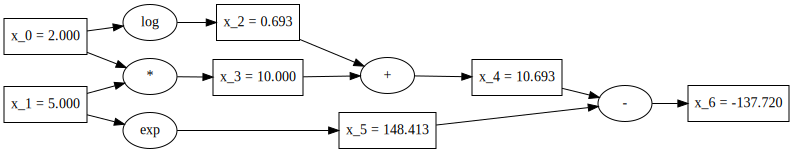

In [6]:
draw_dag_forward(y)

In [7]:
y.backward()

Variable(value=-137.72001192201665, grad=1, name="x_6", op="-", n_parents=2)
Variable(value=10.693147180559945, grad=1, name="x_4", op="+", n_parents=2)
Variable(value=10, grad=1, name="x_3", op="*", n_parents=2)
Variable(value=0.6931471805599453, grad=1, name="x_2", op="log", n_parents=1)
Variable(value=2, grad=5.5, name="x_0", op="", n_parents=0)
Variable(value=148.4131591025766, grad=-1, name="x_5", op="exp", n_parents=1)
Variable(value=5, grad=-146.4131591025766, name="x_1", op="", n_parents=0)


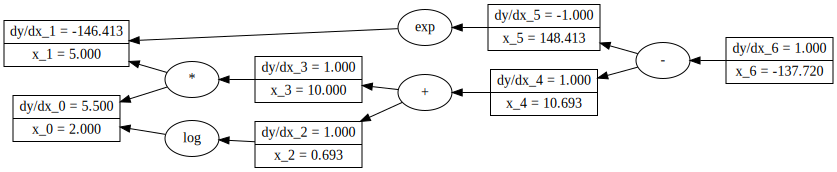

In [8]:
draw_dag_backward(y)

In [12]:
arr = [1, 2, 5 ,6, 7]
arr2 = [2, 7 ,8, 4, 3]
np.log(arr)

array([0.        , 0.69314718, 1.60943791, 1.79175947, 1.94591015])

In [14]:
x = [Variable(x) for x in arr]
s = [Variable(i) for i in arr]

In [15]:
f = np.log(x) + x*s - np.exp(s)

TypeError: can't multiply sequence by non-int of type 'list'